An average strike Asian call option has the payoff
\begin{equation}
    \text{max}(S_T-1/T \cdot\int_0^T S_tdt,0) 
\end{equation}
at the expiration date T. It is assumed that the price of the underlying $S_t$, $0 \leq t \leq T$, follows a 
stochastic process under the risk-neutral measure with stochastic volatility $\sigma_t$ of the following form: 
\begin{split}
    dS_t &= r S_t \, dt + \sigma_t S_t \, dW_t^{(1)} \\
    d\sigma_t^2 &= \kappa (\theta - \sigma_t^2) \, dt + \nu \sigma_t \, dW_t^{(2)} \tag{2}
\end{split}


This setup was introduced by Heston. The stochastic variance follows a mean-reverting process
and leads to introducing skewness that can be observed asset prices. The meaning of the parameters
is the following:
- $r$ risk-free rate (constant)
- $\theta$ long-term mean of the variance
- $\kappa$ speed of adjustment
- $\nu$ volatility of the variance process
$W_t$ is a two-dimensional Wiener process that is $N(0,\Sigma)$ – distributed with covariance matrix:
$$\Sigma=\begin{bmatrix}
    t   & \rho t \\
    \rho t   & t
\end{bmatrix}.$$
An instrument with the path dependent payoff in (1) can be valued using Monte Carlo methods. The
time horizon can be split into $N$ number of intervals. Generating $M$ paths for the asset price one can
approximate the continuous payoff function taking the arithmetic average of the $N+1$ asset prices.
The option price $V_0$ can then be approximated as follows:
\begin{split}
V_0 \approx e^{-rT} \frac{1}{M} \sum_{k=1}^{M} \max \left\{ S_{T,k} - \frac{1}{N+1} \sum_{j=0}^{N} S_{t_j,k}, 0 \right\}.
\end{split}

In the case of one-dimensional autonomous stochastic differential equations of type

\begin{split}
dX_t = a(X_t) \, dt + b(X_t) \, dW_t,
\end{split}

the solution at time $ t_{j+1} $, given the value at $ t_j $, can be approximated by

\begin{split}
X_{t_{j+1}} \approx X_{t_j} + a(X_{t_j})(t_{j+1} - t_j) + b(X_{t_j}) \int_{t_j}^{t_{j+1}} dW_s + \underbrace{b'(X_{t_j}) b(X_{t_j}) \int_{t_j}^{t_{j+1}} \int_{t_j}^s dW_z \, dW_s}_{*} \tag{3}
\end{split}

This is calculated numerically either by

\begin{split}
y_{j+1} = y_j + a(y_j) \, h + b(y_j) \, \Delta W_j
\end{split}

if the term $(*)$ in (3) is ignored, which results in the Euler-Maruyama scheme with strong convergence order 0.5, or by

\begin{split}
y_{j+1} = y_j + a(y_j) \, h + b(y_j) \, \Delta W_j + \frac{1}{2} b'(y_j) b(y_j) (\Delta W_j^2 - h) \tag{4}
\end{split}

where $(*)$ is not truncated and which leads to the Milstein scheme with strong convergence order of 1.

For $n$-dimensional SDEs that involve $m$-dimensional Wiener processes

\begin{split}
W_t = \begin{pmatrix} W_t^{(1)}, \ldots, W_t^{(m)} \end{pmatrix}',
\end{split}

the derivation of the Milstein scheme becomes more complicated.

In this case, we must consider the system

$$
d\begin{pmatrix} X_t^{(1)} \\ \vdots \\ X_t^{(n)} \end{pmatrix} = 
\begin{pmatrix} a^{(1)}(\textbf{X}_t) \\ \vdots \\ a^{(n)}(\textbf{X}_t) \end{pmatrix} dt +\begin{pmatrix} b^{(11)}(\textbf{X}_t) & \cdots & b^{(1m)}(\textbf{X}_t) \\
\vdots & \ddots & \vdots \\
b^{(n1)}(\textbf{X}_t) & \cdots & b^{(nm)}(\textbf{X}_t) 
\end{pmatrix} d 
\begin{pmatrix} W_t^{(1)} \\ \vdots \\ W_t^{(m)} \end{pmatrix}.


# 1. Euler-Maruyama method

It's easy to calculate that the Euler-Maruyama scheme for our model is

\begin{align*}
    \sigma_{t_{j+1}}^2 &= \sigma_{t_j}^2 + k(\theta - \sigma_{t_j}^2) \cdot h + \nu \sigma_{t_j} \Delta W_{t_j}^{(2)}
\end{align*}

and

\begin{align*}
    S_{t_{j+1}} &= S_{t_j} + r S_{t_j} h + \sigma_{t_j} S_{t_j} \Delta W_{t_j}^{(1)}.
\end{align*}


Two remarks:

We use antithetic variables to double the sample size of the MC simulation.

Also, after calculating the value of $\sigma_t^2$, we define it as $\text{max}(\sigma_t^2,0)$, as variance can't be negative. This is known as the truncation method, but we also could have used the reflection method ($|\sigma_t^2|$).

These will be applied to every function defined in this work.

In [11]:
import numpy as np

def asian_option_euler(S0, sigma0, T, kappa, theta, nu, r, rho, M, N):
    h = T / N
    payoffs = np.zeros(2 * M)

    for i in range(M):
        S = S0
        S_antithetic = S0
        sigma = sigma0
        sigma_sq = sigma**2
        sigma_antithetic = sigma0
        sigma_sq_antithetic = sigma_antithetic**2
        
        S_path = np.zeros(N + 1)
        S_path_antithetic = np.zeros(N + 1)
        S_path[0] = S
        S_path_antithetic[0] = S_antithetic
        
        for t in range(N):
            z1 = np.random.normal()
            z2 = np.random.normal()
            dw1 = np.sqrt(h) * z1
            dw2 = np.sqrt(h) * (rho * z1 + np.sqrt(1 - rho**2) * z2)
            dw1_antithetic = -dw1
            dw2_antithetic = -dw2

            # Variance - original path
            sigma_sq = sigma_sq + kappa * (theta - sigma_sq) * h + nu * sigma * dw2
            sigma_sq = max(sigma_sq, 0)
            sigma = np.sqrt(sigma_sq)
            
            # Variance - antithetic path
            sigma_sq_antithetic = sigma_sq_antithetic + kappa * (theta - sigma_sq_antithetic) * h + nu * sigma_antithetic * dw2_antithetic
            sigma_sq_antithetic = max(sigma_sq_antithetic, 0)
            sigma_antithetic = np.sqrt(sigma_sq_antithetic)
            
            # Asset - original path
            S = S + r * S * h + sigma * S * dw1
            S_path[t + 1] = S
            
            # Asset - antithetic path
            S_antithetic = S_antithetic + r * S_antithetic * h + sigma_antithetic * S_antithetic * dw1_antithetic
            S_path_antithetic[t + 1] = S_antithetic
        
        payoffs[2 * i] = max(S_path[-1] - np.mean(S_path), 0)
        payoffs[2 * i + 1] = max(S_path_antithetic[-1] - np.mean(S_path_antithetic), 0)
    
    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price


## 1.1 Convergence

M = 500, Monte Carlo Option Price = 8.3313
M = 1000, Monte Carlo Option Price = 8.4645
M = 2000, Monte Carlo Option Price = 8.9136
M = 3000, Monte Carlo Option Price = 8.7908
M = 4000, Monte Carlo Option Price = 8.6870
M = 5000, Monte Carlo Option Price = 8.6641
M = 10000, Monte Carlo Option Price = 8.6382
M = 50000, Monte Carlo Option Price = 8.7744
M = 100000, Monte Carlo Option Price = 8.7439
M = 200000, Monte Carlo Option Price = 8.7254


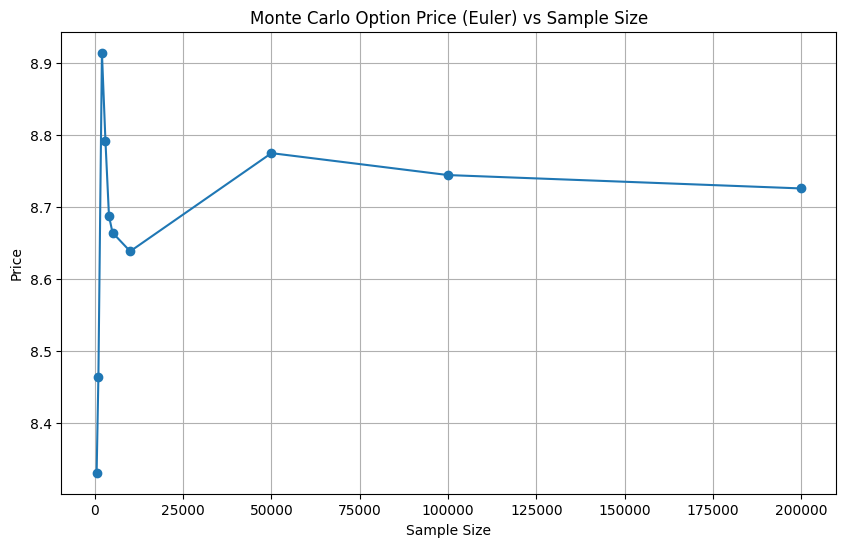

In [34]:
import matplotlib.pyplot as plt

S0 = 100 
sigma0 = 0.25 
T = 1 
kappa = 2  
theta = 0.1 
nu = 0.2 
r = 0.05  
rho = 0.2 
N = 100 
M_values = [500, 1000, 2000, 3000, 4000, 5000, 10000, 50000, 100000, 200000]

np.random.seed(42)

option_prices = []

for M in M_values:
    price = asian_option_euler(S0, sigma0, T, kappa, theta, nu, r, rho, M, N)
    option_prices.append(price)
    print(f"M = {M}, Monte Carlo Option Price = {price:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(M_values, option_prices, marker='o')
plt.title('Monte Carlo Option Price (Euler) vs Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Price')
plt.grid(True)
plt.show()

As we can see, the graph gets flatter, that is, the differences in the results get smaller as the sample size increases.

Therefore the simulation seems to be converging to the true solution.

Let's examine the rate of convergence.

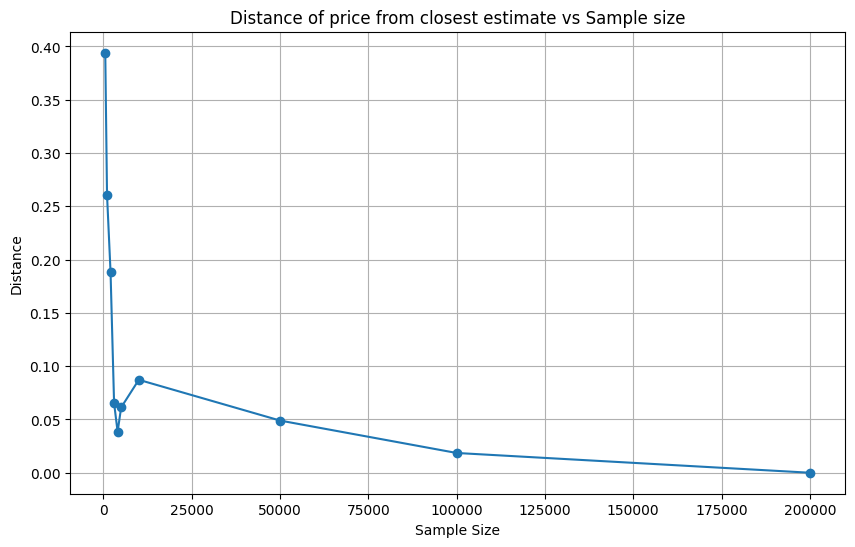

In [46]:
distances = abs(option_prices-option_prices[-1])
plt.figure(figsize=(10, 6))
plt.plot(M_values, distances, marker='o')
plt.title('Distance of price from closest estimate vs Sample size')
plt.xlabel('Sample Size')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

The rate of convergence seems to be $O(\frac{1}{M})$.

## 1.2 Sensitivity

We use the same parameters as in 1.1, so the long term mean of volatility is $\sqrt{\theta} = \sqrt{\frac{1}{10}} \approx 0.316$.

sigma_0 = 0.1, Monte Carlo Option Price = 8.1979
sigma_0 = 0.15, Monte Carlo Option Price = 8.3676
sigma_0 = 0.2, Monte Carlo Option Price = 8.5423
sigma_0 = 0.25, Monte Carlo Option Price = 8.7829
sigma_0 = 0.31622776601683794, Monte Carlo Option Price = 9.0923
sigma_0 = 0.35, Monte Carlo Option Price = 9.2057
sigma_0 = 0.4, Monte Carlo Option Price = 9.5613
sigma_0 = 0.45, Monte Carlo Option Price = 9.8506
sigma_0 = 0.5, Monte Carlo Option Price = 10.4384


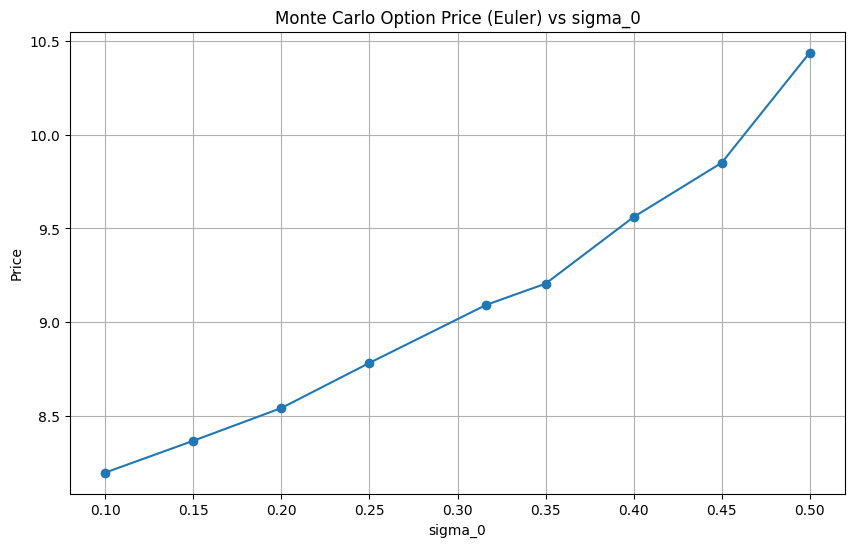

In [27]:
S0 = 100 
sigma0_values = [0.10, 0.15, 0.20, 0.25, np.sqrt(0.1), 0.35, 0.40, 0.45, 0.50 ]
T = 1 
kappa = 2  
theta = 0.1 
nu = 0.2 
r = 0.05  
rho = 0.2 
N = 100 
M = 20000

np.random.seed(42)

option_prices_sigma0 = []

for sigma0 in sigma0_values:
    price = asian_option_euler(S0, sigma0, T, kappa, theta, nu, r, rho, M, N)
    option_prices_sigma0.append(price)
    print(f"sigma_0 = {sigma0}, Monte Carlo Option Price = {price:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(sigma0_values, option_prices_sigma0, marker='o')
plt.title('Monte Carlo Option Price (Euler) vs sigma_0')
plt.xlabel('sigma_0')
plt.ylabel('Price')
plt.grid(True)
plt.show()

As with any call option, the price has positive vega, that is, volatility increases the price (This is clear, since the buyer doesn't lose as much on a very low asset price at maturity as they win on a very high asset price at maturity).

This is also true for our average strike option, as higher volatility increases the probability that the difference between the average price and the price at maturity is large, therefore increasing our expected payoff.

In our case, increasing the initial volatility increases the volatility throughout the path, causing the effects described above (note however, the further we are from maturity, the less impactful the initial volatility is on the price).

Also worth mentioning that in the Heston-model, the diffusion term also has $\sigma_t$ in it, meaning higher (initial) volatility implies higher volofvol, which also increases the price of the call option.

## 1.3 Constant volatility

Let's compare our results with an identical product but assuming constant volatility.

We can use our previous results with $\kappa=\nu=0$.

In [14]:
def asian_option_euler_constantvol(S0, sigma0, T, r, M, N):
    h = T / N
    payoffs = np.zeros(2 * M)

    for i in range(M):
        S = S0
        S_antithetic = S0
        sigma = sigma0
        sigma_antithetic = sigma0
        
        S_path = np.zeros(N + 1)
        S_path_antithetic = np.zeros(N + 1)
        S_path[0] = S
        S_path_antithetic[0] = S_antithetic
        
        for t in range(N):
            z1 = np.random.normal()
            dw1 = np.sqrt(h) * z1
            dw1_antithetic = -dw1
            
            # Asset - original path
            S = S + r * S * h + sigma * S * dw1
            S_path[t + 1] = S
            
            # Asset - antithetic path
            S_antithetic = S_antithetic + r * S_antithetic * h + sigma_antithetic * S_antithetic * dw1_antithetic
            S_path_antithetic[t + 1] = S_antithetic
        
        payoffs[2 * i] = max(S_path[-1] - np.mean(S_path), 0)
        payoffs[2 * i + 1] = max(S_path_antithetic[-1] - np.mean(S_path_antithetic), 0)
    
    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price

M = 500, Monte Carlo Option Price = 7.1962
M = 1000, Monte Carlo Option Price = 6.8211
M = 2000, Monte Carlo Option Price = 6.9593
M = 3000, Monte Carlo Option Price = 7.1201
M = 4000, Monte Carlo Option Price = 6.9366
M = 5000, Monte Carlo Option Price = 6.9466
M = 10000, Monte Carlo Option Price = 6.8647
M = 50000, Monte Carlo Option Price = 6.9481
M = 100000, Monte Carlo Option Price = 6.9530
M = 200000, Monte Carlo Option Price = 6.9548


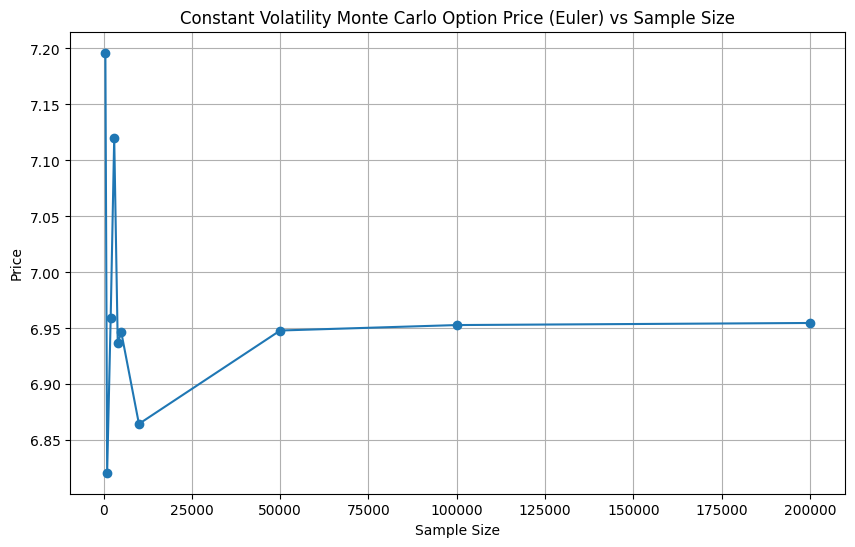

In [15]:
S0 = 100 
sigma0 = 0.25 
T = 1 
kappa = 2  
theta = 0.1 
nu = 0.2 
r = 0.05  
rho = 0.2 
N = 100 
M_values = [500, 1000, 2000, 3000, 4000, 5000, 10000, 50000, 100000, 200000]

np.random.seed(42)

option_prices = []

for M in M_values:
    price = asian_option_euler_constantvol(S0, sigma0, T, r, M, N)
    option_prices.append(price)
    print(f"M = {M}, Monte Carlo Option Price = {price:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(M_values, option_prices, marker='o')
plt.title('Constant Volatility Monte Carlo Option Price (Euler) vs Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Price')
plt.grid(True)
plt.show()

As we can see, the simulation converges as before.

We can observe that the price of the option is significantly lower, but that's not surprising, as the (constant) volatility is lower that the long term mean of volatility, therefore the volatility gets higher in the Heston case.

Let's examine different values for $\sigma=\sigma_0$.

sigma_0 = 0.1, Monte Carlo Option Price = 3.6981
sigma_0 = 0.15, Monte Carlo Option Price = 4.7412
sigma_0 = 0.2, Monte Carlo Option Price = 5.8428
sigma_0 = 0.25, Monte Carlo Option Price = 6.9596
sigma_0 = 0.31622776601683794, Monte Carlo Option Price = 8.2597
sigma_0 = 0.35, Monte Carlo Option Price = 9.2557
sigma_0 = 0.4, Monte Carlo Option Price = 10.3416
sigma_0 = 0.45, Monte Carlo Option Price = 11.4721
sigma_0 = 0.5, Monte Carlo Option Price = 12.5518


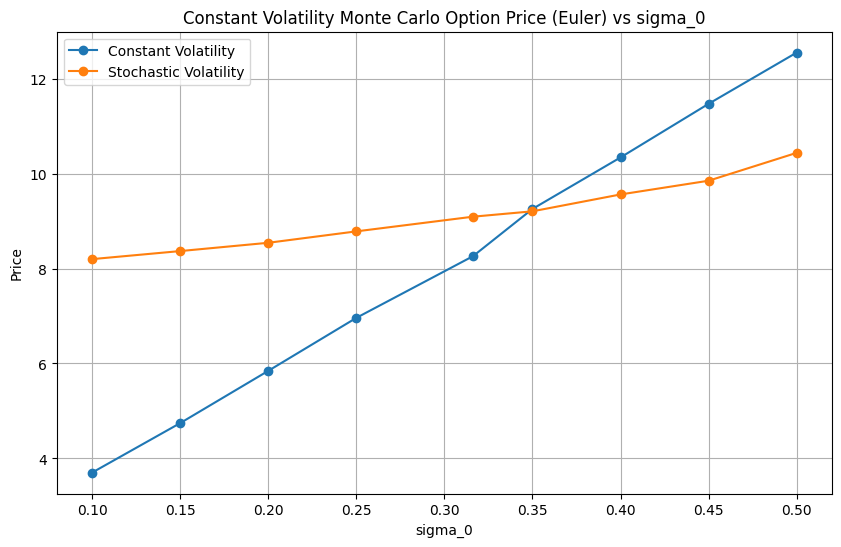

In [29]:
S0 = 100 
sigma0_values = [0.10, 0.15, 0.20, 0.25, np.sqrt(0.1), 0.35, 0.40, 0.45, 0.50 ]
T = 1 
kappa = 2  
theta = 0.1 
nu = 0.2 
r = 0.05  
rho = 0.2 
N = 100 
M = 20000

np.random.seed(42)

option_prices = []

for sigma0 in sigma0_values:
    price = asian_option_euler_constantvol(S0, sigma0, T, r, M, N)
    option_prices.append(price)
    print(f"sigma_0 = {sigma0}, Monte Carlo Option Price = {price:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(sigma0_values, option_prices, marker='o', label='Constant Volatility')
plt.plot(sigma0_values, option_prices_sigma0, marker='o', label='Stochastic Volatility')
plt.title('Constant Volatility Monte Carlo Option Price (Euler) vs sigma_0')
plt.xlabel('sigma_0')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

As expected and explained before, the price increases as the volatility increases.

We can observe that if $\sigma_0 < \sqrt{\theta}$, then the price is lower for constant volatility, since the volatility stays low, but it increases to $\sqrt{\theta}$ in the stochastic volatility case.

Similarly, if $\sigma_0 > \sqrt{\theta}$, then the price is higher for constant volatility, since the volatility stays high, but it decreases to $\sqrt{\theta}$ in the stochastic volatility case.

When $\sigma_0 = \sqrt{\theta}$, the price is slightly lower in the constant volatility case, as volofvol increases the price.

# 2. Milstein method


Let $\textbf{W}$ be an m-dimensional Wiener process with correlation matrix $(\rho_{ij})_{1\leq i,j\leq m}$. 

Take the following n-dimensional SDE:

$$
d\begin{pmatrix} X_t^{(1)} \\ \vdots \\ X_t^{(n)} \end{pmatrix} = 
\begin{pmatrix} a^{(1)}(\textbf{X}_t) \\ \vdots \\ a^{(n)}(\textbf{X}_t) \end{pmatrix} dt +\begin{pmatrix} b^{(11)}(\textbf{X}_t) & \cdots & b^{(1m)}(\textbf{X}_t) \\
\vdots & \ddots & \vdots \\
b^{(n1)}(\textbf{X}_t) & \cdots & b^{(nm)}(\textbf{X}_t) 
\end{pmatrix} d 
\begin{pmatrix} W_t^{(1)} \\ \vdots \\ W_t^{(m)} \end{pmatrix},
$$

i.e.:

$$
d\textbf{X}_t=\textbf{a}(\textbf{X}_t)dt+\textbf{B}(\textbf{X}_t)d\textbf{W}_t.
$$

Similarly to the one dimensional case, given the value at $t_j$, the solution at $t_{j+1}$ can be approximated by

\begin{align*}
    X_{t_{j+1}}^{(i)} &\approx X_{t_j}^{(i)} + a^{(i)}(\textbf{X}_{t_j})(t_{j+1}-t_j) + \sum_{k=1}^{m} b^{(i k)}(\textbf{X}_{t_j}) \int_{t_j}^{t_{j+1}} dW_s^{(k)} \\
    &\quad + \sum_{x=1}^{m} \sum_{y=1}^{m} \sum_{z=1}^{n} \frac{\partial b^{(i x)}(\textbf{X}_{t_j})}{\partial X_{t_j}^{(z)}} b^{(z y)}(\textbf{X}_{t_j}) \left( \int_{t_j}^{t_{j+1}} \int_{t_j}^{s} dW_r^{(y)} dW_s^{(x)} \right).
\end{align*}

We know that

$$
\int_{t_j}^{t_{j+1}} \int_{t_j}^{s} dW_r^{(y)} dW_s^{(x)} \approx
\frac{1}{2}(\Delta W_{t_j}^{(x)}\Delta W_{t_j}^{(y)}-\rho_{xy}h).
$$

Therefore we can numerically calculate the above equation as

\begin{align*}
    X_{t_{j+1}}^{(i)} &\approx X_{t_j}^{(i)} + a^{(i)}(\textbf{X}_{t_j})h + \sum_{k=1}^{m} b^{(i k)}(\textbf{X}_{t_j}) \Delta W_{t_j}^{(k)} \\
    &\quad + \frac{1}{2} \sum_{x=1}^{m} \sum_{y=1}^{m} \sum_{z=1}^{n} \frac{\partial b^{(i x)}(\textbf{X}_{t_j})}{\partial X_{t_j}^{(z)}} b^{(z y)}(\textbf{X}_{t_j}) \left( \Delta W_{t_j}^{(x)}\Delta W_{t_j}^{(y)}-\rho_{xy}h\right).
\end{align*}

In our case, for the Heston model, we have

$$
\textbf{X}_t = \begin{pmatrix} S_t \\ \sigma_t^2 \end{pmatrix}, \quad \textbf{a}(\textbf{X}_t) = \begin{pmatrix} r S_t \\ \kappa(\theta - \sigma_t^2) \end{pmatrix}, \quad \textbf{B}(\textbf{X}_t) = \begin{pmatrix} \sigma_t S_t & 0 \\ 0 & \nu \sigma_t \end{pmatrix}.
$$

Therefore our equations become

\begin{align*}
    \sigma_{t_{j+1}}^2 &= \sigma_{t_j}^2 + k(\theta - \sigma_{t_j}^2) \cdot h + \nu \sigma_{t_j} \Delta W_{t_j}^{(2)} + \frac{1}{2} \left( \nu \cdot \frac{1}{2} \cdot \frac{1}{\sigma_{t_j}} \cdot \nu \sigma_{t_j} \right) \left( \left( \Delta W_{t_j}^{(2)} \right)^2 - h \right) \\
    &= \sigma_{t_j}^2 + k(\theta - \sigma_{t_j}^2) \cdot h + \nu \sigma_{t_j} \Delta W_{t_j}^{(2)} + \frac{\nu^2}{4} \left( \left( \Delta W_{t_j}^{(2)} \right)^2 - h \right),
\end{align*}

and

\begin{align*}
    S_{t_{j+1}} &= S_{t_j} + r S_{t_j} h + \sigma_{t_j} S_{t_j} \Delta W_{t_j}^{(1)} + \frac{1}{2} \sigma_{t_j} \cdot \sigma_{t_j} S_{t_j} \cdot \left( \left( \Delta W_{t_j}^{(1)} \right)^2 - h \right)\\
    &\quad + \frac{1}{2}S_{t_j} \frac{1}{2} \frac{1}{\sigma_{t_j}} \cdot \nu \sigma_{t_j} \left( \Delta W_{t_j}^{(1)} \Delta W_{t_j}^{(2)} \right)\\
    &= S_{t_j} + r S_{t_j} h + \sigma_{t_j} S_{t_j} \Delta W_{t_j}^{(1)} + \frac{1}{2} \sigma_{t_j}^2 S_{t_j}\left( \left( \Delta W_{t_j}^{(1)} \right)^2 - h \right)\\
    &\quad + \frac{1}{4}S_{t_j} \nu \left( \Delta W_{t_j}^{(1)} \Delta W_{t_j}^{(2)} - \rho h \right).
\end{align*}

In [16]:
def asian_option_milstein(S0, sigma0, T, kappa, theta, nu, r, rho, M, N):
    h = T / N
    payoffs = np.zeros(2*M)
    
    for i in range(M):
        S = S0
        sigma = sigma0
        sigma_sq = sigma**2
        S_antithetic = S0
        sigma_antithetic = sigma0
        sigma_sq_antithetic = sigma_antithetic**2
        
        S_path = np.zeros(N + 1)
        S_path_antithetic = np.zeros(N + 1)
        S_path[0] = S
        S_path_antithetic[0] = S_antithetic
        
        for t in range(N):
            z1 = np.random.normal()
            z2 = np.random.normal()
            dw1 = np.sqrt(h) * z1
            dw2 = np.sqrt(h) * (rho * z1 + np.sqrt(1 - rho**2) * z2)
            dw1_antithetic = -dw1
            dw2_antithetic = -dw2
            
            # Variance - original path
            sigma_sq = sigma_sq + kappa * (theta - sigma_sq) * h + nu * sigma * dw2 + 0.25 * nu**2 * (dw2**2 - h)
            sigma_sq = max(sigma_sq, 0)
            sigma = np.sqrt(sigma_sq)
            
            # Variance - antithetic path
            sigma_sq_antithetic = sigma_sq_antithetic + kappa * (theta - sigma_sq_antithetic) * h + nu * sigma_antithetic * dw2_antithetic + 0.25 * nu**2 * (dw2_antithetic**2 - h)
            sigma_sq_antithetic = max(sigma_sq_antithetic, 0) 
            sigma_antithetic = np.sqrt(sigma_sq_antithetic)
            
            # Asset - original path
            S = S + r * S * h + sigma * S * dw1 + 0.5 * sigma_sq * S * (dw1**2 - h) + 0.25 * S * nu * (dw1*dw2 - rho*h)
            S_path[t + 1] = S

            # Asset - antithetic path
            S_antithetic = S_antithetic + r * S_antithetic * h + sigma_antithetic * S_antithetic * dw1_antithetic + 0.5 * sigma_sq_antithetic * S_antithetic * (dw1_antithetic**2 - h) + 0.25 * S_antithetic * nu * (dw1_antithetic*dw2_antithetic - rho*h)
            S_path_antithetic[t + 1] = S_antithetic
        
        payoff = max(S_path[-1] - np.mean(S_path), 0)
        payoff_antithetic = max(S_path_antithetic[-1] - np.mean(S_path_antithetic), 0)
        
        payoffs[2 * i] = payoff
        payoffs[2 * i + 1] = payoff_antithetic
    
    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price


## 2.1 Convergence

M = 500, Monte Carlo Option Price  = 8.3606
M = 1000, Monte Carlo Option Price  = 8.4659
M = 2000, Monte Carlo Option Price  = 8.9075
M = 3000, Monte Carlo Option Price  = 8.7854
M = 4000, Monte Carlo Option Price  = 8.6791
M = 5000, Monte Carlo Option Price  = 8.6578
M = 10000, Monte Carlo Option Price  = 8.6349
M = 50000, Monte Carlo Option Price  = 8.7743
M = 100000, Monte Carlo Option Price  = 8.7438
M = 200000, Monte Carlo Option Price  = 8.7238


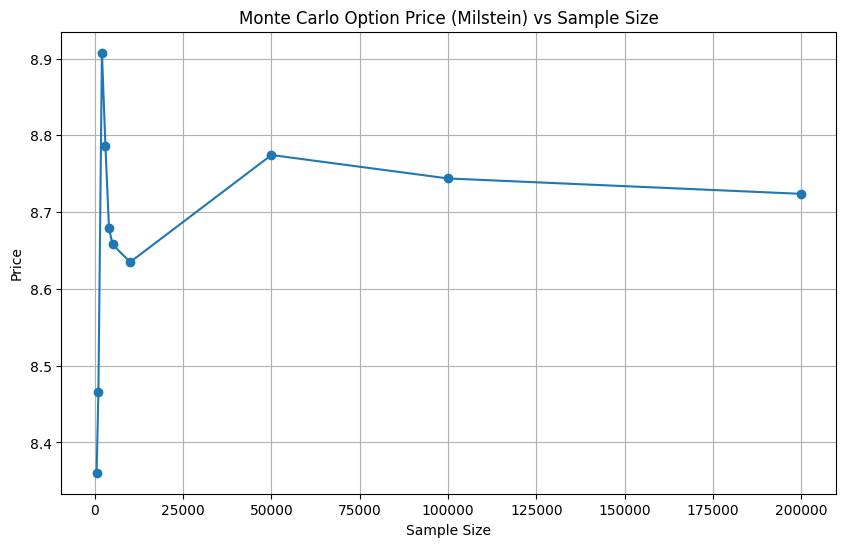

In [36]:
S0 = 100 
sigma0 = 0.25 
T = 1
kappa = 2
theta = 0.1   
nu = 0.2 
r = 0.05
rho = 0.2
N = 100
M_values = [500, 1000, 2000, 3000, 4000, 5000, 10000, 50000, 100000, 200000]

np.random.seed(42)

option_prices_milstein = []

for M in M_values:
    price = asian_option_milstein(S0, sigma0, T, kappa, theta, nu, r, rho, M, N)
    option_prices_milstein.append(price)
    print(f"M = {M}, Monte Carlo Option Price  = {price:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(M_values, option_prices_milstein, marker='o')
plt.title('Monte Carlo Option Price (Milstein) vs Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Price')
plt.grid(True)
plt.show()

As we can see, the graph gets flatter, that is, the differences in the results get smaller as the sample size increases.

Therefore the simulation seems to be converging to the true solution.

Let's examine the rate of convergence.

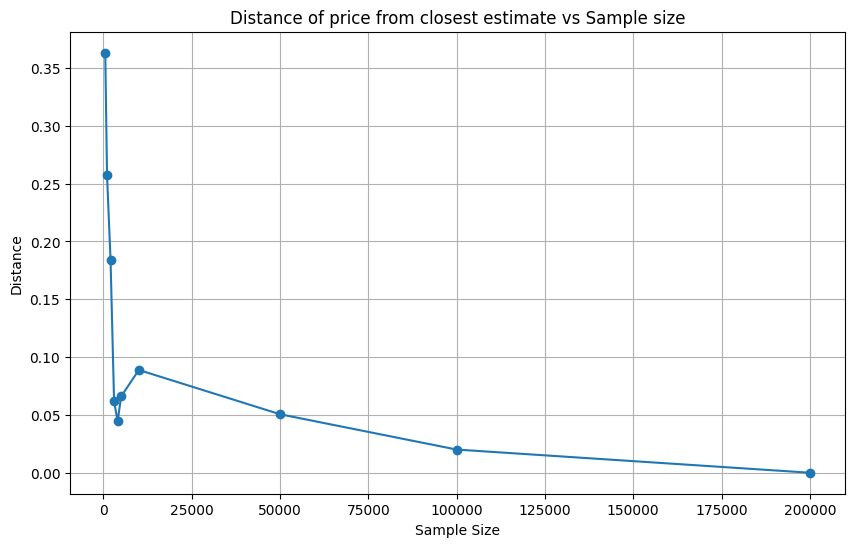

In [44]:
distances = abs(option_prices_milstein-option_prices_milstein[-1])
plt.figure(figsize=(10, 6))
plt.plot(M_values, distances, marker='o')
plt.title('Distance of price from closest estimate vs Sample size')
plt.xlabel('Sample Size')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

Note that the speed of convergence didn't increase, as the Milstein method increases the rate of convergence in terms of $N$.

## 2.2 Sensitivity

sigma_0 = 0.1, Monte Carlo Option Price = 8.1942
sigma_0 = 0.15, Monte Carlo Option Price = 8.3690
sigma_0 = 0.2, Monte Carlo Option Price = 8.5411
sigma_0 = 0.25, Monte Carlo Option Price = 8.7828
sigma_0 = 0.31622776601683794, Monte Carlo Option Price = 9.0895
sigma_0 = 0.35, Monte Carlo Option Price = 9.2050
sigma_0 = 0.4, Monte Carlo Option Price = 9.5606
sigma_0 = 0.45, Monte Carlo Option Price = 9.8489
sigma_0 = 0.5, Monte Carlo Option Price = 10.4328


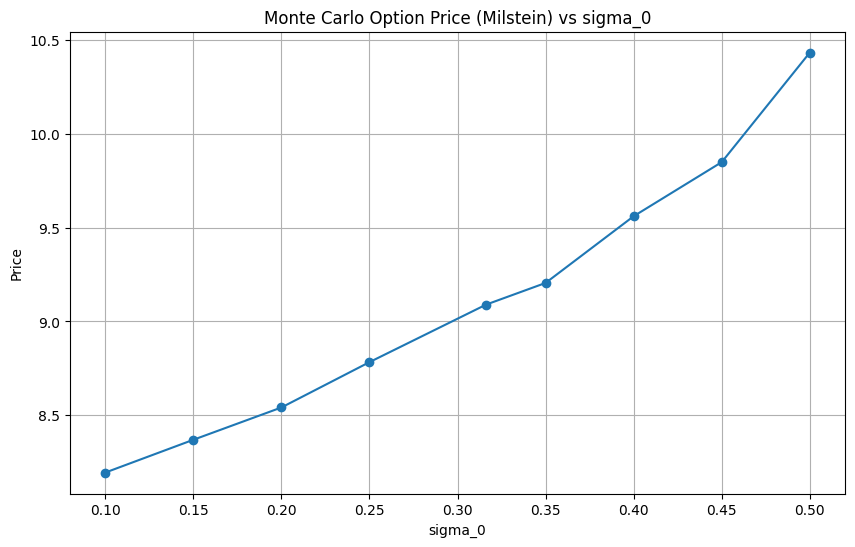

In [30]:
S0 = 100 
sigma0_values = [0.10, 0.15, 0.20, 0.25, np.sqrt(0.1), 0.35, 0.40, 0.45, 0.50 ]
T = 1 
kappa = 2  
theta = 0.1 
nu = 0.2 
r = 0.05  
rho = 0.2 
N = 100 
M = 20000

np.random.seed(42)

option_prices_sigma0 = []

for sigma0 in sigma0_values:
    price = asian_option_milstein(S0, sigma0, T, kappa, theta, nu, r, rho, M, N)
    option_prices_sigma0.append(price)
    print(f"sigma_0 = {sigma0}, Monte Carlo Option Price = {price:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(sigma0_values, option_prices_sigma0, marker='o')
plt.title('Monte Carlo Option Price (Milstein) vs sigma_0')
plt.xlabel('sigma_0')
plt.ylabel('Price')
plt.grid(True)
plt.show()

Again, the price increases as $\sigma_0$ increases, the reasoning is the same.

## 2.3 Constant volatility

We can use our previous results with $\kappa=\nu=0$.

In [19]:
def asian_option_milstein_constantvol(S0, sigma0, T, r, M, N):
    h = T / N
    payoffs = np.zeros(2*M)
    
    for i in range(M):
        S = S0
        sigma = sigma0
        sigma_sq = sigma**2
        S_antithetic = S0
        sigma_antithetic = sigma0
        sigma_sq_antithetic = sigma_antithetic**2
        
        S_path = np.zeros(N + 1)
        S_path_antithetic = np.zeros(N + 1)
        S_path[0] = S
        S_path_antithetic[0] = S_antithetic
        
        for t in range(N):
            z1 = np.random.normal()
            dw1 = np.sqrt(h) * z1
            dw1_antithetic = -dw1
            
            # Asset - original path
            S = S + r * S * h + sigma * S * dw1 + 0.5 * sigma_sq * S * (dw1**2 - h)
            S_path[t + 1] = S

            # Asset - antithetic path
            S_antithetic = S_antithetic + r * S_antithetic * h + sigma_antithetic * S_antithetic * dw1_antithetic + 0.5 * sigma_sq_antithetic * S_antithetic * (dw1_antithetic**2 - h)
            S_path_antithetic[t + 1] = S_antithetic
        
        payoff = max(S_path[-1] - np.mean(S_path), 0)
        payoff_antithetic = max(S_path_antithetic[-1] - np.mean(S_path_antithetic), 0)
        
        payoffs[2 * i] = payoff
        payoffs[2 * i + 1] = payoff_antithetic
    
    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price


M = 500, Monte Carlo Option Price  = 7.1897
M = 1000, Monte Carlo Option Price  = 6.8152
M = 2000, Monte Carlo Option Price  = 6.9534
M = 3000, Monte Carlo Option Price  = 7.1164
M = 4000, Monte Carlo Option Price  = 6.9345
M = 5000, Monte Carlo Option Price  = 6.9486
M = 10000, Monte Carlo Option Price  = 6.8618
M = 50000, Monte Carlo Option Price  = 6.9441
M = 100000, Monte Carlo Option Price  = 6.9497
M = 200000, Monte Carlo Option Price  = 6.9518


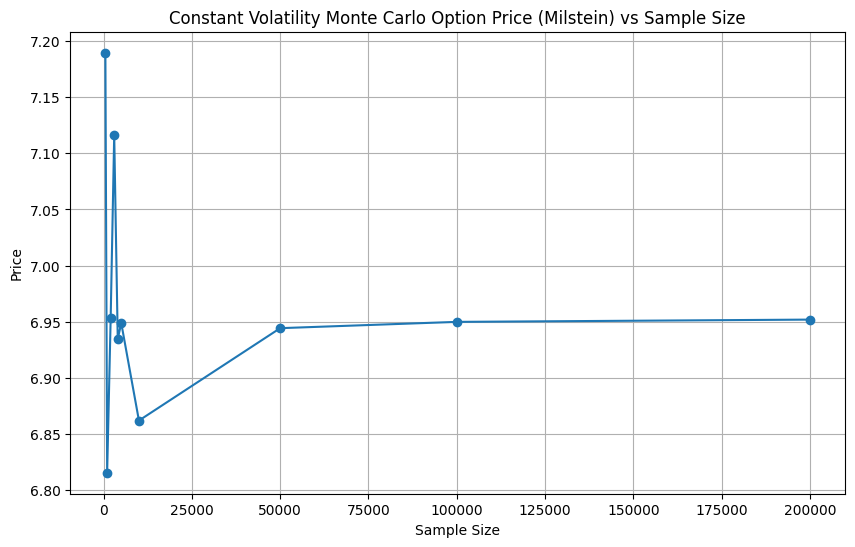

In [20]:
S0 = 100 
sigma0 = 0.25 
T = 1
kappa = 2
theta = 0.1   
nu = 0.2 
r = 0.05
rho = 0.2
N = 100
M_values = [500, 1000, 2000, 3000, 4000, 5000, 10000, 50000, 100000, 200000]

np.random.seed(42)

option_prices_milstein = []

for M in M_values:
    price = asian_option_milstein_constantvol(S0, sigma0, T, r, M, N)
    option_prices_milstein.append(price)
    print(f"M = {M}, Monte Carlo Option Price  = {price:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(M_values, option_prices_milstein, marker='o')
plt.title('Constant Volatility Monte Carlo Option Price (Milstein) vs Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Price')
plt.grid(True)
plt.show()

We observe the price to be lower again, similarly as before.

Let's examine other values of $\sigma=\sigma_0$.

sigma_0 = 0.1, Monte Carlo Option Price = 3.6976
sigma_0 = 0.15, Monte Carlo Option Price = 4.7391
sigma_0 = 0.2, Monte Carlo Option Price = 5.8412
sigma_0 = 0.25, Monte Carlo Option Price = 6.9566
sigma_0 = 0.31622776601683794, Monte Carlo Option Price = 8.2511
sigma_0 = 0.35, Monte Carlo Option Price = 9.2491
sigma_0 = 0.4, Monte Carlo Option Price = 10.3325
sigma_0 = 0.45, Monte Carlo Option Price = 11.4586
sigma_0 = 0.5, Monte Carlo Option Price = 12.5310


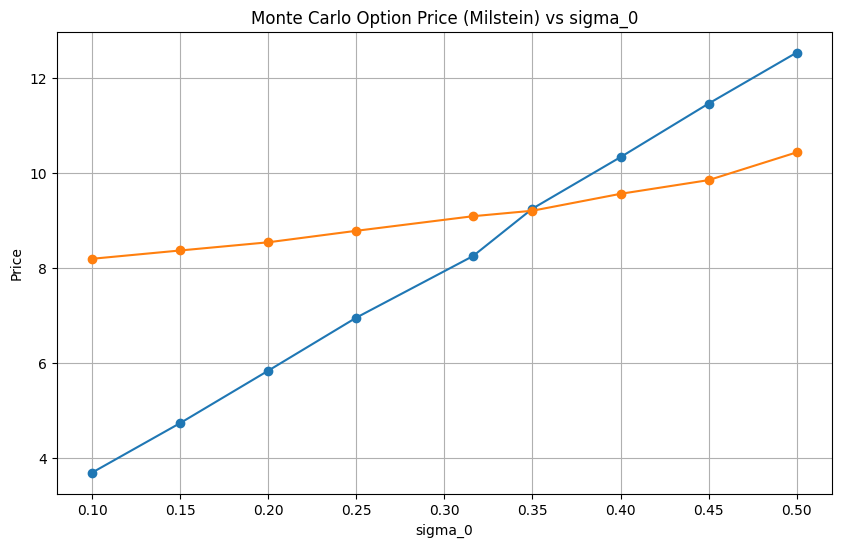

In [32]:
S0 = 100 
sigma0_values = [0.10, 0.15, 0.20, 0.25, np.sqrt(0.1), 0.35, 0.40, 0.45, 0.50 ]
T = 1 
kappa = 2  
theta = 0.1 
nu = 0.2 
r = 0.05  
rho = 0.2 
N = 100 
M = 20000

np.random.seed(42)

option_prices = []

for sigma0 in sigma0_values:
    price = asian_option_milstein_constantvol(S0, sigma0, T,  r, M, N)
    option_prices.append(price)
    print(f"sigma_0 = {sigma0}, Monte Carlo Option Price = {price:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(sigma0_values, option_prices, marker='o', label='Constant Volatility')
plt.plot(sigma0_values, option_prices_sigma0, marker='o', label='Stochastic Volatility')
plt.title('Monte Carlo Option Price (Milstein) vs sigma_0')
plt.xlabel('sigma_0')
plt.ylabel('Price')
plt.legend
plt.grid(True)
plt.show()

We can make the same observations:

As expected and explained before, the price increases as the volatility increases.

We can observe that if $\sigma_0 < \sqrt{\theta}$, then the price is lower for constant volatility, since the volatility stays low, but it increases to $\sqrt{\theta}$ in the stochastic volatility case.

Similarly, if $\sigma_0 > \sqrt{\theta}$, then the price is higher for constant volatility, since the volatility stays high, but it decreases to $\sqrt{\theta}$ in the stochastic volatility case.

When $\sigma_0 = \sqrt{\theta}$, the price is slightly lower in the constant volatility case, as volofvol increases the price.